In [1]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np

In [4]:
def Feature1(image_path):
    """This function calculates the number of white pixels present in the image """
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
    plt.plot(histogram)
    threshold =200
    white_px = int(np.sum(histogram[threshold + 1:]))
    return f"{white_px/image.size:.4f}"
    
    

In [5]:
def Feature2(image_mat):
    frobenius_norm = np.linalg.norm(image_mat, 'fro')
    
    if frobenius_norm == 0:
        raise ValueError("The Frobenius norm is zero, cannot normalize.")
    
    # Normalize the image array by the Frobenius norm
    normalized_image = image_mat / frobenius_norm
    
    return normalized_image
    

In [6]:
def image_to_2d_array(image_path):
   
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    mat = image
    return mat


In [9]:
def Feature3(image_path, lower_threshold=50, upper_threshold=200):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    
    # Create a mask for high-contrast regions (intensity outside the threshold range)
    high_contrast_mask = (image < lower_threshold) | (image > upper_threshold)
    
    # Extract the high-contrast region as a submatrix
    high_contrast_region = image[high_contrast_mask]
    
    if high_contrast_region.size == 0:
        raise ValueError("No high-contrast regions detected in the image.")
    
    # Compute the Frobenius norm for the high-contrast region
    frobenius_norm = np.linalg.norm(high_contrast_region, ord=2)
    
    if frobenius_norm == 0:
        raise ValueError("The Frobenius norm is zero, cannot normalize.")
    
    # Normalize the high-contrast region
    normalized_region = high_contrast_region / frobenius_norm
    
    # Update the high-contrast regions in the original image with normalized values
    normalized_image = image.astype(float)  # Convert to float for normalization
    normalized_image[high_contrast_mask] = normalized_region
    
    return normalized_image
    

0.0484
<class 'numpy.ndarray'>
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


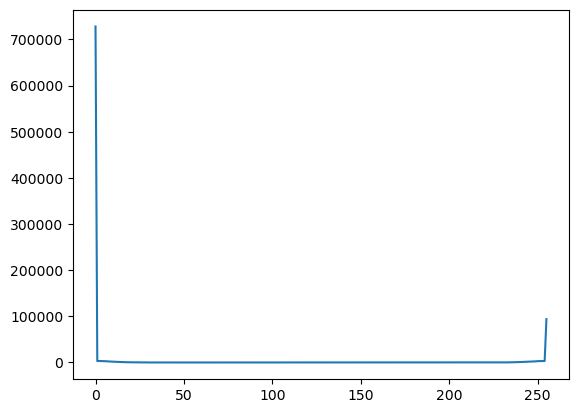

In [10]:
print(Feature1(r"D:\paper\waterLevel\data_1\299.jpg"))
image_mat = image_to_2d_array(r"D:\paper\waterLevel\data_1\299.jpg")
print(type(image_mat))
print(Feature2(image_mat))
print(Feature3(r"D:\paper\waterLevel\data_1\299.jpg"))